# 株価予測でお金持ちになろう（！？）

Pythonの基本文法は一通り見れたので、最後にPythonの得意領域である機械学習に触れてみましょう！

Pythonには機械学習を実行する上で便利なライブラリが様々あり、もはや機械学習をする上で必須な技術と言っても過言ではありません。
今回は「**株価予測**」タスクについて、データ取得〜予測まで一気通貫でやってみます。

In [1]:
!pip install yfinance
!pip install mplfinance
!pip install plotly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.3/60.3 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 1.2 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 4.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 3.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.0/143.0 kB 2.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 11.6 MB/s eta 0:00:00
  Using cached webencodings-0.5.1-py2.py3-none-any.whl (11 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.7/124.7 kB 5.8 MB/s eta 0:00:00
  Using cached idna-3.4-py3-none-any.whl (61 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.2/123.2 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.0/157.0 kB 2.7 MB/s eta 0:00:00a 0:00:01
  Using cached pycparser-2.21-py2.py3-none

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import plotly.graph_objects as go
import plotly.figure_factory as ff

# 株価分析に役立つライブラリ
import yfinance as yf
import mplfinance as mpf

In [ ]:
# 任天堂の株価情報をAPIを用いて簡単に取得できる！
# みんなもティアーズオブザキングダム買おう！！
ticker = "7974.T"
df_all = yf.download(ticker, start= "2011-01-01",end="2021-12-31", interval = "1d")
df_all.head()

カラムの意味
- Date：取得日時
- Open：始値
- High：高値
- Low：底値
- Close：終値
- Adj Close：調整後終値...株式分割の実施の前後で株価を連続的にとらえるために、分割実施前の終値を分割後の値に調整した終値
- Volume：出来高...株式の取引量

In [ ]:
# mplfinanceによる株式プロット
# 上：株価推移
# 下：株式取引量
mpf.plot(df_all, type="candle",volume=True, figratio=(10,5))

# 特徴量エンジニアリング・データ分析

今回は調整後株価(Adj Close)を予測することについて考える。

※調整後株価とは、株式分割等のイベントによる株価への影響を除いた、感覚値として正しい株価のこと。

In [ ]:
# 今回の目的変数：1日後の調整後終値を作る
df_all['Close_next'] = df_all['Adj Close'].shift(-1)
df_all.tail()

In [ ]:
# 前日のAdj Closeの値(すでにあるAdj Closeがそのまま該当する)
df_all = df_all.rename(columns={'Adj Close':'Close_pre1'})
df_all.head()

In [ ]:
# 前日との差
df_all['Close_diff_pre1'] = df_all['Close_pre1'].diff(1)
df_all.head()

In [ ]:
# 移動平均
SMA1 = 5   #短期5日
SMA2 = 10  #中期10日
SMA3 = 15  #長期15日
df_all['SMA5'] = df_all['Close_pre1'].rolling(SMA1).mean() #短期移動平均の算出
df_all['SMA10'] = df_all['Close_pre1'].rolling(SMA2).mean() #中期移動平均の算出
df_all['SMA15'] = df_all['Close_pre1'].rolling(SMA3).mean() #長期移動平均の算出
df_all.head(20)

In [ ]:
# 欠損値を消す
df_all = df_all.dropna(how='any')
df_all.head()

In [ ]:
# もう使わないのでAdj Closeは消しておく
# でないと予測したいはずの値を使って予測するとかいうおかしな事になってしまうので...
df_all = df_all.drop(['Close'], axis=1)

In [ ]:
# 相関行列を生成

import plotly.graph_objects as go
df_corr = df_all.corr()

fig = go.Figure()
fig.add_trace(
    go.Heatmap(
        x = df_corr.columns,
        y = df_corr.index,
        z = np.array(df_corr) 
    )
)

これでも視覚的に分かりやすいのですが、テキストとして相関係数が書かれていたり、色のグラデーションでより直感的に相関の大小関係が分かった方が良いですよね？  
以下でこのヒートマップを改善してみましょ〜

In [ ]:
# より見やすく！！！
import plotly.figure_factory as ff
x = list(df_corr.columns)
y = list(df_corr.index)
z = np.array(df_corr)

fig = ff.create_annotated_heatmap(
    z,
    x = x,
    y = y ,
    annotation_text = np.around(z, decimals=3),
    hoverinfo='z',
    colorscale='OrRd'
    )
fig.show()

最初のやつと比べて、相関係数を表示＆カラースケールを白→赤の順に変化させるようにしました！  
本当はもっと良い感じに見やすくなるのですが、今回は相関が高すぎて真っ赤ですね...

# モデリング
今回使う機械学習アルゴリズムは「**重回帰分析**」です！

これは「予測対象データ(目的変数)を予測に使うデータ(説明変数)で再現する式を作るために、各種説明変数にかける適切な係数と切片を**誤差の二乗を最小にする(最小二乗法)**ように計算する」

という考えを実行したもので、機械学習手法の中で最も単純な仕組みで計算されている手法です！

数式で説明すると以下の様になります。

$$y = \beta + \alpha_1 x_1 + \alpha_2 x_2 + ... + \alpha_n x_n$$

$$y...目的変数（次の日の終値）$$
$$\beta ... 切片$$
$$\alpha ... 偏回帰係数$$
$$x...説明変数（前の日の終値等）$$

数式アレルギーの人がいるかもしれないのでもう一度言葉で説明すると、「モデルに入力した色々な値に係数を掛けて翌日の株価を再現しやすい式を作る」ということを説明しています。  


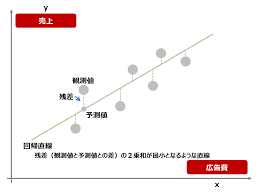

In [ ]:
from sklearn.linear_model import LinearRegression
# 時系列分割のためTimeSeriesSplitのインポート
from sklearn.model_selection import TimeSeriesSplit
# 予測精度検証のためMSEをインポート
from sklearn.metrics import mean_squared_error as mse

In [ ]:
train = df_all[:'2021-01-01']
test = df_all['2021-01-01':]

# 学習用データとテストデータそれぞれを説明変数と目的変数に分離する
X_train = train.drop('Close_next', axis=1) #学習用データ説明変数
y_train = train['Close_next'] #学習用データ目的変数
X_test = test.drop('Close_next', axis=1) #テストデータ説明変数
y_test = test['Close_next'] #テストデータ目的変数

In [ ]:
# 時系列分割交差検証
valid_scores = []
tscv = TimeSeriesSplit(n_splits=4)
for fold, (train_indices, valid_indices) in enumerate(tscv.split(X_train)):
    X_train_cv, X_valid_cv = X_train.iloc[train_indices], X_train.iloc[valid_indices]
    y_train_cv, y_valid_cv = y_train.iloc[train_indices], y_train.iloc[valid_indices]
    # 線形回帰モデルのインスタンス化
    model = LinearRegression()
    # モデル学習
    model.fit(X_train_cv, y_train_cv)
    # 予測
    y_valid_pred = model.predict(X_valid_cv)
    # 予測精度(RMSE)の算出
    score = np.sqrt(mse(y_valid_cv, y_valid_pred))
    # 予測精度スコアをリストに格納
    valid_scores.append(score)

In [ ]:
print(f'valid_scores: {valid_scores}')
cv_score = np.mean(valid_scores)
print(f'CV score: {cv_score}')

In [ ]:
# 可視化
model = LinearRegression()
model.fit(X_train, y_train)
df_result = test[['Close_next']]
df_result['Close_pred'] = model.predict(X_test)
df_result

In [ ]:
print('RMSE：', np.sqrt(mse(df_result['Close_next'], df_result['Close_pred'])))
df_result.plot()

これで、みんなもお金持ちですね！（）

# ~このAIが使えない理由~

皆さんお疲れ様でした！
さて、お金持ちになる前に、ちょっとこの重回帰モデルについて深掘りしてみましょうか

In [ ]:
# 予測結果を拡大してみてみると...？
df_result.iloc[:20,:].plot()
# 全然ダメで草

上の予測結果を完全に信じて挑戦すると、予測の向き(上がるか下がるか)で大きく間違えている箇所でドツボにハマりそうですね（笑）

In [ ]:
# 試しに今回のモデルの偏回帰係数・切片を見てみると...？

model_params = list(model.coef_).copy() # 偏回帰係数
model_params.append(model.intercept_) # 切片
columns = list(X_train.columns).copy()
columns.append("intercept")
df_params = pd.DataFrame(model_params, index=columns).T

# 表示
display(df_params)
df_params.plot.bar()

~やっぱり~しょーもないモデルでしたね🐦

今回の分析に対して、一体何が問題だったのか考えてみましょう。

1. 株価は人の心理が動かしている面が強く、不足の事態として急激な値動きに対応できていない。(拡大すると分かりやすい)
2. 考慮している変数が少なすぎて、株価を左右する要因をカバーしきれていない。（例えば、その企業の取引先の企業の株価だったり、日経平均等を用いた日本全体の景気等）
3. 説明変数同士で相関が高いものを入れすぎて、適切な回帰係数が計算できていない(多重共線性という)
4. (要因分析という観点では)説明変数の単位がそれぞれ違うものが含まれていて、一概に回帰係数の値で重要度が比較できない(ただし、回帰係数の符号は大丈夫)
5. 直接的な予測対象であるAdj Closeやその大元であるCloseは削除したものの、その日の終わりでしか分からないはずのHighやLowも説明変数に加えている(実質答えを見ながら予測している状態で、実戦では使い物にならないモデルということが簡単に分かる)

残念ながら、重回帰分析の仕組み上株価予測は難しいのです...

じゃあもっとマシなアプローチはあるの？というと、上下どちらに動くかというやや単純化したタスクの予測させるAIを強化学習というアプローチで作成して買い付けを行わせたり、時系列回帰が得意なモデルにデータを食わせたりすることがあるそうです。  
**（私は責任を負いませんが）**皆さんも頑張って株価を予測させて、是非お金持ちになってください🐦

# オマケ：時系列モデル「ARIMA」で予測

In [ ]:
# 先程判明した前処理における問題点を解決しておく
df_all = df_all.drop(['Open', 'High', 'Low', 'SMA5', 'SMA10', 'SMA15'], axis=1)

In [ ]:
# 確認する
df_corr = df_all.corr()
x = list(df_corr.columns)
y = list(df_corr.index)
z = np.array(df_corr)

fig = ff.create_annotated_heatmap(
    z,
    x = x,
    y = y ,
    annotation_text = np.around(z, decimals=3),
    hoverinfo='z',
    colorscale='OrRd'
    )
fig.show()

In [ ]:
train = df_all[:'2021-01-01']
test = df_all['2021-01-01':]

# 学習用データとテストデータそれぞれを説明変数と目的変数に分離する
X_train = train.drop('Close_next', axis=1) #学習用データ説明変数
y_train = train['Close_next'] #学習用データ目的変数
X_test = test.drop('Close_next', axis=1) #テストデータ説明変数
y_test = test['Close_next'] #テストデータ目的変数

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
# ARIMAモデル実装
model = ARIMA(y_train, order=(6,1,0))
model_fit = model.fit()
print(model_fit.summary())

In [ ]:
history = [x for x in y_train]
model_predictions = []
for time_point in range(len(y_test)):
    #ARIMAモデル 実装
    model = ARIMA(history, order=(6,1,0))
    model_fit = model.fit()
    #予測データの出力
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    #トレーニングデータの取り込み
    true_test_value = y_test[time_point]
    history.append(true_test_value)

In [ ]:
# pred = pd.DataFrame(model_predictions, columns=['Close'])
# pred = pred.set_index(df_all.index)
df_result = test[['Close_next']]
df_result['Close_pred'] = np.array(model_predictions)
df_result

In [ ]:
print('RMSE：', np.sqrt(mse(df_result['Close_next'], df_result['Close_pred'])))
df_result.plot()
# ちょっとだけ良くなった？

In [ ]:
# 予測結果を拡大してみてみると...？
df_result.iloc[:20,:].plot()
# やっぱりダメそうで草

# 参考文献
- Pythonで予測｜株価はいくらになる？【機械学習を使って予測する方法を解説：データ取得、データ前処理、モデル作成、モデル評価まで】、キノコード、https://kino-code.com/python-stock-price2/
- 【実践】Pythonで株の取引データを分析し予測してみよう！、スタビジ、https://toukei-lab.com/python_stock

# LICENCE

このcolabは[githubのREADME](https://github.com/agu-piedpiper/piedpiper-python)にて記載の通りのライセンスに従います。